# How to: Find EMIT Data using NASA's CMR API and Download

**Summary**  

This notebook will explain how to access Earth Surface Minteral Dust Source Investigation (EMIT) data programmaticly using NASA's CMR API. The Common Metadata Repository (CMR) is a metadata system that catalogs Earth Science data and associated metadata records. The CMR Application Programming Interface (API) provides programatic search capabilities through CMR's vast metadata holdings using various parameters and keywords. When querying NASA's CMR, there is a limit of 1 million granules matched and only 2000 granules returned per page. 

**Requirements:**
+ A NASA [Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download EMIT data   
+ Selected the `emit_tutorials` environment as the kernel for this notebook.
  + For instructions on setting up the environment, follow the the `setup_instructions.md` included in the `/setup/` folder of the repository.  

**Learning Objectives**  
- How to find EMIT data using NASA's CMR API
- How to download programmaticly 

---

Import the required packages

In [1]:
# %pip install geopandas

import requests
import pandas as pd
import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, box

---

## Obtaining the Concept ID

NASA EarthData's unique ID for this dataset (called Concept ID) is needed for searching the dataset. The dataset Digital Object Identifier or DOI can be used to obtain the Concept ID. DOIs can be found by clicking the `Citation` link on the LP DAAC's [EMIT Product Pages](https://lpdaac.usgs.gov/product_search/?query=emit&view=cards&sort=title).

In [2]:
doi = '10.5067/EMIT/EMITL1BRAD.001'# EMIT L1B TOA Radiance

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id)

C2408009906-LPCLOUD


This is the unique NASA-given concept ID for the EMIT L2A Reflectance dataset, which can be used to retrieve relevant files (or granules).

---

## Searching using CMR API

When searching the CMR API, users can provide spatial bounds and date-time ranges to narrow their search. These spatial bounds can be either, points, a bounding box, or a polygon. 

Specify start time and dates and reformat them to the structure necessary for searching CMR.

In [3]:
# Temporal Bound - Year, month, day. Hour, minutes, and seconds (ZULU) can also be included 
# Let's start by stepping through each day to see if there was EMIT data recorded.

start_date = dt.datetime(2025, 1, 11)
end_date = dt.datetime(2025, 1, 12, 23, 59, 59)  



# Let's create a list of temporal strings that each span 1 day
num_days = [*range(start_date.day,end_date.day+1,1)]              # range(start_value, end_value (not included), step

# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'

temporal_str = [None]*len(num_days)         # define an empty list

for idx, val in enumerate(num_days):
    start_day = dt.datetime(2022, 8, val)
    end_day = dt.datetime(2022, 8, val, 23, 59, 59)
    temporal_str[idx] = start_day.strftime(dt_format) + ',' + end_day.strftime(dt_format)
    
print(temporal_str)

['2022-08-11T00:00:00Z,2022-08-11T23:59:59Z', '2022-08-12T00:00:00Z,2022-08-12T23:59:59Z']


In [4]:
print(num_days)

[11, 12]


The CMR API only allows 2000 results to be shown at a time. Using `page_num` allows a user to loop through the search result pages. The sections below walk through using Points, Bounding Boxes, and Polygons to spatially constrain a search made using the CMR API. 

### Search using Points

To search using a point we specify a latitude and longitude.

In [5]:
# Let's step through each day defined above, and search for coincident measurements between 
# EMIT and CERES FM6 within some defined time constraint

# Search using a Point

# What happens if we set no point?
# By not defining a location but just a temporal constraint, we can find all EMIT files within that time window

#lon = 92.5274
#lat = 48.893
#point_str = str(lon) +','+ str(lat)

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

for idx, val in enumerate(temporal_str):
    # define the day to search
    day2search = temporal_str[idx]

    while True:
    
        # defining parameters
        cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": day2search,
        }

        granulesearch = cmrurl + 'granules.json'
        response = requests.post(granulesearch, data=cmr_param)
        granules = response.json()['feed']['entry']
       
        if granules:
            for g in granules:
                granule_urls = ''
                granule_poly = ''

                # read cloud cover
                # This is a percentage from 0 to 100
                cloud_cover = g['cloud_cover']
                
                # read in EMIT start time of measurement recording
                time_start = g['time_start']
                # convert time string to a datetime object
                time_start = dt.datetime.strptime(time_start[0:-5] + 'Z', dt_format)
                

                # reading bounding geometries
                if 'polygons' in g:
                    polygons= g['polygons']
                    multipolygons = []
                    for poly in polygons:
                        i=iter(poly[0].split (" "))
                        ltln = list(map(" ".join,zip(i,i)))
                        multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                    granule_poly = MultiPolygon(multipolygons)
            
                # Get https URLs to .nc files and exclude .dmrpp files
                granule_urls = [x['href'] for x in g['links'] if 'https' in x['href'] and '.nc' in x['href'] and '.dmrpp' not in x['href']]
                # Add to list
                granule_arr.append([granule_urls, cloud_cover, time_start, granule_poly])

            page_num += 1
        else: 
            break
print(granule_arr)

[[['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220811T001233_2222216_001/EMIT_L1B_RAD_001_20220811T001233_2222216_001.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220811T001233_2222216_001/EMIT_L1B_OBS_001_20220811T001233_2222216_001.nc'], '1', datetime.datetime(2022, 8, 11, 0, 12, 33), <MULTIPOLYGON (((-120.44 41.349, -120.833 40.663, -119.95 40.157, -119.557 4...>], [['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220811T001245_2222216_002/EMIT_L1B_RAD_001_20220811T001245_2222216_002.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220811T001245_2222216_002/EMIT_L1B_OBS_001_20220811T001245_2222216_002.nc'], '74', datetime.datetime(2022, 8, 11, 0, 12, 45), <MULTIPOLYGON (((-119.656 40.905, -120.061 40.222, -118.646 39.384, -118.241...>], [['https://data.lpdaac.earthdatacloud.

In [6]:
test = granule_arr[0][-1]


In [7]:
gpd.GeoSeries([granule_arr[0][-1]]).to_json()

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "MultiPolygon", "coordinates": [[[[-120.4399414, 41.3494987], [-120.8331604, 40.6633263], [-119.9503174, 40.1574059], [-119.5570984, 40.8435783], [-120.4399414, 41.3494987]]]]}, "bbox": [-120.8331604, 40.1574059, -119.5570984, 41.3494987]}], "bbox": [-120.8331604, 40.1574059, -119.5570984, 41.3494987]}'

In [8]:
## Now with the granules found above, we want to see if there is a coincident measurement with the CERES Single Scanner Footprint data product within some alloted time window

# This CERES data is recorded every hour, every day. So to check, we need to determine if any of the individual footprints overlap with EMIT. Therefore we only need the metadata that is within our time window

# # EMIT-NOAA-20
# CERES FM6 SSF L21B, The TOA/Single Scanner Footprint (SSF) product, 
# contains one hour of instantaneous CERES data for a single scanner instrument.
# For info on the CERES-FM6 products, see the link below
# https://ceres.larc.nasa.gov/data/data-product-dois/#noaa20-edition1
doi_ceres = '10.5067/NOAA20/CERES/SSF-FM6_L2.001B'# CERES FM6 on NOAA-20 SSF 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi_ceres
concept_id_ceres = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id_ceres)


C2246001744-LARC_ASDC


In [9]:
test = 10
print(test/2)

5.0


In [10]:
# Now we will search for CERES data
# We will search over the polygon defined from the granule found above
# We will search within a time window defined by the granules above

page_num = 1
page_size = 2000 # CMR page size limit

# Define the time window
time_window = 10                 # minutes

granule_arr_ceres = []

for idx, val in enumerate(granule_arr[0]):
    # define the day to search
    start_time_2search = granule_arr[idx][2] - dt.timedelta(minutes=(time_window/2))
    end_time_2search = granule_arr[idx][2] + dt.timedelta(minutes=(time_window/2))
    time2search = dt.datetime.strftime(start_time_2search, dt_format) + ',' + dt.datetime.strftime(end_time_2search, dt_format)
    # Define a geo-json file using the polygon shapefile using the EMIT footprint
    # This is the area that will be searched
    geojson = {"shapefile": ("test.geojson", gpd.GeoSeries([granule_arr[idx][-1]]).to_json(), "application/geo+json")}

    while True:
    
        # defining parameters
        cmr_param = {
        "collection_concept_id": concept_id_ceres, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": time2search,
        "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
        }

        granulesearch = cmrurl + 'granules.json'
        response = requests.post(granulesearch, data=cmr_param, files=geojson)
        granules = response.json()['feed']['entry']
        
       
        if granules:
            for g in granules:
                granule_urls = ''
                granule_poly = ''

                # read cloud cover
                # This is a percentage from 0 to 100
                #cloud_cover = g['cloud_cover']

                # reading bounding geometries
                if 'polygons' in g:
                    polygons= g['polygons']
                    multipolygons = []
                    for poly in polygons:
                        i=iter(poly[0].split (" "))
                        ltln = list(map(" ".join,zip(i,i)))
                        multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                    granule_poly = MultiPolygon(multipolygons)
            
                # Get https URLs to .nc files and exclude .dmrpp files
                granule_urls = [x['href'] for x in g['links'] if 'https' in x['href'] and '.nc' in x['href'] and '.dmrpp' not in x['href']]
                # Add to list
                granule_arr_ceres.append([granule_urls, granule_poly])

            page_num += 1
        else: 
            break
print(granule_arr_ceres)

[]


In [14]:
print(granule_arr[37])


[['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220811T043349_2222303_025/EMIT_L1B_RAD_001_20220811T043349_2222303_025.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220811T043349_2222303_025/EMIT_L1B_OBS_001_20220811T043349_2222303_025.nc'], '90', datetime.datetime(2022, 8, 11, 4, 33, 49), <MULTIPOLYGON (((80.022 41.938, 79.021 41.382, 79.407 40.686, 80.409 41.242,...>]


In [15]:
print(granules)

[]


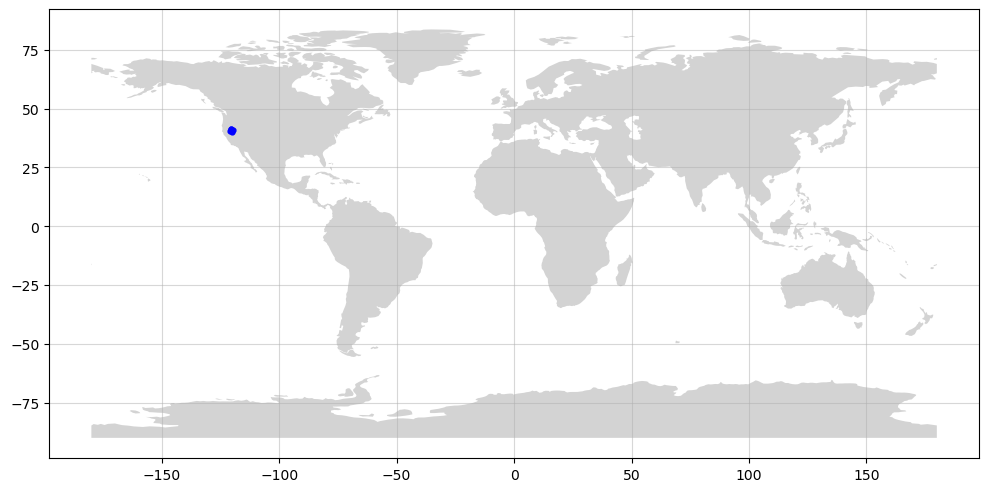

In [16]:
# initialize an axis
# %pip install geodatasets

import geodatasets

fig, ax = plt.subplots(figsize=(12,10))
# plot map on axis
countries = gpd.read_file(geodatasets.get_path("naturalearth.land"))
countries.plot(color="lightgrey", ax=ax)

long,lat = granule_arr[0][len(granule_arr[0])-1].geoms[0].exterior.xy
# for some reason the longitude is the wrong sign
correct_long = [ x for x in long]
# plot points
ax.scatter(correct_long, lat, s = 12, c="blue")
# reduce the view of the plot
# plt.xlim(50, 100)     # set the xlim to left, right
# plt.ylim(15, 30)
# add grid
ax.grid(visible=True, alpha=0.5)
plt.show()

In [17]:
print(temporal_str[0])

2022-08-11T00:00:00Z,2022-08-11T23:59:59Z


In [18]:
print(g)

{'time_start': '2022-08-11T04:33:49.000Z', 'cloud_cover': '90', 'updated': '2023-01-20T20:38:27.000Z', 'dataset_id': 'EMIT L1B At-Sensor Calibrated Radiance and Geolocation Data 60 m V001', 'data_center': 'LPCLOUD', 'title': 'EMIT_L1B_RAD_001_20220811T043349_2222303_025', 'coordinate_system': 'GEODETIC', 'day_night_flag': 'DAY', 'time_end': '2022-08-11T04:34:01.000Z', 'id': 'G2593587657-LPCLOUD', 'original_format': 'UMM_JSON', 'granule_size': '1869.8283796310423', 'browse_flag': True, 'polygons': [['41.9376602 80.0224457 41.3820267 79.0209808 40.6861877 79.4070435 41.2418213 80.4085083 41.9376602 80.0224457']], 'collection_concept_id': 'C2408009906-LPCLOUD', 'online_access_flag': True, 'links': [{'rel': 'http://esipfed.org/ns/fedsearch/1.1/service#', 'title': 'OPeNDAP request URL', 'hreflang': 'en-US', 'href': 'https://opendap.earthdata.nasa.gov/collections/C2408009906-LPCLOUD/granules/EMIT_L1B_RAD_001_20220811T043349_2222303_025'}, {'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#', 

### Search using a bounding box
For this we'll use a bounding box along the coast of Argentina with a bottom left corner of -62.1123 Longitude, -39.89402 Latitude, and a top right corner of -61.70801 Longitude and -39.57769 Latitude.

In [ ]:


# Search Using a Bounding Box
# first 2 points = bottom left corner of box: (long, lat)
# second 2 points = top right corner of box: (long, lat)

bound = (90.2109, 45.8472, 122.2460, 69.4354) 
bound_str = ','.join(map(str,bound))

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    
     # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,          # <-- TIME CONSTRAINT HERE
        "bounding_box[]":bound_str         # <-- SPATIAL CONSTRAINT HERE
    }

    granulesearch = cmrurl + 'granules.json'
    response = requests.post(granulesearch, data=cmr_param)
    granules = response.json()['feed']['entry']
       
    if granules:
        for g in granules:
            granule_urls = ''
            granule_poly = ''
                       
            # read cloud cover
            cloud_cover = g['cloud_cover']
    
            # reading results bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get https URLs to .nc files and exclude .dmrpp files
            granule_urls = [x['href'] for x in g['links'] if 'https' in x['href'] and '.nc' in x['href'] and '.dmrpp' not in x['href']]
            # Add to list
            granule_arr.append([granule_urls, cloud_cover, granule_poly])
                           
        page_num += 1
    else: 
        break
print(granule_arr)

[]


### Search a Polygon

A polygon can also be used to spatially search using the CMR API. A shapefile, geojson, or other format can be opened as a geopandas dataframe, then reformatted to a geojson format to be sent as a parameter in the CMR search. Note that very complex shapefiles must be simplified, there is a 5000 coordinate limit.

In [49]:
# Search using a Polygon
#polygon = gpd.read_file('isla_gaviota.geojson')
#polygon = gpd.GeoSeries([granule_arr[0][-1]]).to_json()
geojson = {"shapefile": ("test.geojson", gpd.GeoSeries([granule_arr[0][-1]]).to_json(), "application/geo+json")}

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    
     # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
    }

    granulesearch = cmrurl + 'granules.json'
    response = requests.post(granulesearch, data=cmr_param, files=geojson)
    granules = response.json()['feed']['entry']
       
    if granules:
        for g in granules:
            granule_urls = ''
            granule_poly = ''
                       
            # read granule title and cloud cover
            granule_name = g['title']
            cloud_cover = g['cloud_cover']
    
            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get https URLs to .nc files and exclude .dmrpp files
            granule_urls = [x['href'] for x in g['links'] if 'https' in x['href'] and '.nc' in x['href'] and '.dmrpp' not in x['href']]
            # Add to list
            granule_arr.append([granule_urls, cloud_cover, granule_poly])
                           
        page_num += 1
    else: 
        break
 
print(granule_arr)

[[['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220810T052528_2222204_032/EMIT_L1B_RAD_001_20220810T052528_2222204_032.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220810T052528_2222204_032/EMIT_L1B_OBS_001_20220810T052528_2222204_032.nc'], '7', <MULTIPOLYGON (((93.364 49.359, 92.064 49.03, 92.25 48.294, 93.551 48.623, 9...>], [['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220810T052540_2222204_033/EMIT_L1B_RAD_001_20220810T052540_2222204_033.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220810T052540_2222204_033/EMIT_L1B_OBS_001_20220810T052540_2222204_033.nc'], '44', <MULTIPOLYGON (((95.185 49.789, 93.107 49.299, 93.282 48.559, 95.36 49.05, 9...>], [['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220810T083923_2222206_037

> Note: At the time this tutorial was made, all 3 searches, point, bounding box, and polygon should result in the same assets being returned.

### Creating a Dataframe with the resulting Links

A `pandas.dataframe` can be used to store the download URLs and geometries of each file. The EMIT L2A Reflectance and Uncertainty and Mask collection contains 3 assets per granule (reflectance, reflectance uncertainty, and masks). We can see when printing this list, that there are three assets that correspond to a single polygon. For the next step we will place these into a dataframe and 'explode' the dataframe to place each of these in a separate row. If we only want a subset of these assets, we can filter them out. 

In [50]:
# creating a pandas dataframe
cmr_results_df = pd.DataFrame(granule_arr, columns=["asset_url", "cloud_cover", "granule_poly"])
# Drop granules with empty geometry - if any exist
cmr_results_df = cmr_results_df[cmr_results_df['granule_poly'] != '']
# Expand so each row contains a single url 
cmr_results_df = cmr_results_df.explode('asset_url')
# Name each asset based on filename
cmr_results_df.insert(0,'asset_name', cmr_results_df.asset_url.str.split('/',n=-1).str.get(-1))

cmr_results_df

,asset_name,asset_url,cloud_cover,granule_poly
0,EMIT_L1B_RAD_001_20220810T052528_2222204_032.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,7,"MULTIPOLYGON (((93.3643036 49.3594284, 92.0636..."
0,EMIT_L1B_OBS_001_20220810T052528_2222204_032.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,7,"MULTIPOLYGON (((93.3643036 49.3594284, 92.0636..."
1,EMIT_L1B_RAD_001_20220810T052540_2222204_033.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,44,"MULTIPOLYGON (((95.1851349 49.7891693, 93.1072..."
1,EMIT_L1B_OBS_001_20220810T052540_2222204_033.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,44,"MULTIPOLYGON (((95.1851349 49.7891693, 93.1072..."
2,EMIT_L1B_RAD_001_20220810T083923_2222206_037.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,25,"MULTIPOLYGON (((92.8937759 49.8073044, 92.7262..."
2,EMIT_L1B_OBS_001_20220810T083923_2222206_037.nc,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,25,"MULTIPOLYGON (((92.8937759 49.8073044, 92.7262..."


At this stage we can filter based on the assets that we want or the cloud cover. For this example lets say we are only interested in the Reflectance and the Mask. To filter by asset, we can match strings included in the asset name. 

In [51]:
cmr_results_df = cmr_results_df[cmr_results_df.asset_name.str.contains('_RFL_') | cmr_results_df.asset_name.str.contains('MASK')]
cmr_results_df

,asset_name,asset_url,cloud_cover,granule_poly


After filtering down to the assets you want, you can output a text file with the asset urls or save the entire dataframe, then use a utility such as wget or the DAAC Data Download Tool to download the files. To download you will need to set up NASA Earthdata Login authentication using  a .netrc file. 

Save the asset urls to a textfile in the `/data/` folder.

In [52]:
# Save text file of asset urls
cmr_results_dfs = cmr_results_df[:-1].drop_duplicates(subset=['asset_url']) # Remove any duplicates
cmr_results_df.to_csv('../data/emit_asset_urls.txt', columns = ['asset_url'], index=False, header = False)

OSError: Cannot save file into a non-existent directory: '../data'

---  

## Downloading Files using the list of URLS/Text File

To download the files using the DAAC Data Downloader, clone that repository and execute the python script included from the command line.

In [ ]:
!git clone https://git.earthdata.nasa.gov/scm/lpdur/daac_data_download_python.git ../daac_data_download_python/

In [ ]:
!python ../daac_data_download_python/DAACDataDownload.py -dir ../data/ -f ../data/emit_asset_urls.txt

To download using wget, use the following in the command line.

In [ ]:
!wget -P ../data/ -i ../data/emit_asset_urls.txt

---

## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 01-20-2023  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I. 